In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def get_a_priori_bound_Qz(f,gamma,endpts,k,w,lmin,lmax):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| (Q_{w,z})^{k+1} |dz|
    """
    
    def F(t):
        z,dz = gamma(t)
                
        return (1/(2*np.pi)) * np.abs(f(z)) * Q_wz(w,z,lmin,lmax)**(2*k) * Q_z(z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral


In [4]:
def get_a_posteriori_bound_Qz(f,gamma,endpts,a_,b_,w,lmin,lmax):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,z}| Q_{w,z} |dz|
    """
    
    theta = sp.linalg.eigvalsh_tridiagonal(a_,b_,tol=1e-30)

    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.abs(np.prod((theta-w)/(theta-z)))**2 * Q_z(z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

## Setup

In [5]:
n = 3000
m = 2*n
X = np.random.randn(n,m)/np.sqrt(2*n)
A = X@X.T
lam = np.linalg.eigvalsh(A)
#lam = np.load('matrices/Erdos992_eigs.npy')
#lam /= np.min(np.abs(lam))
n = len(lam)

b = np.ones(n,dtype=np.longdouble)
b /= np.linalg.norm(b)

lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

In [6]:
w = 0

# norm to measure function approximation and linear system errors
B = np.ones(n)

In [7]:
K = 40
reorth=True
Q,(a_,b_) = exact_lanczos(lam.astype(np.longdouble),b.astype(np.longdouble),K+1,reorth=reorth)

In [8]:
plot_tol = 1e-14

In [9]:
T = np.zeros((3,K+1))
T[0,1:] = b_
T[1] = a_-w
T[2,:-1] = b_

e1 = np.zeros(K+1)
e1[0] = 1

In [10]:
err_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = (1/(lam-w))*b - np.linalg.norm(b)*Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1])
        err_CG[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_CG[k] < plot_tol:
        break

In [11]:
res_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        r = b - np.linalg.norm(b)*(lam-w)*(Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1]))
        res_CG[k] = np.sqrt( r@r )
    except: pass
    
    if res_CG[k] < plot_tol:
        break

In [12]:
Anorm_estimate = np.full(K,np.nan)
Anorm_bound = np.full(K,np.nan)

d = 10

for k in range(0,K):
    try:
        Tk_inv_e1 = sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1])
        e = (1/(lam-w))*b - np.linalg.norm(b)*Q[:,:k+1]@Tk_inv_e1
                
        if k+d+1<K:
            Tkd_inv_e1 = sp.linalg.solve_banded((1,1),T[:,:k+d+1],e1[:k+d+1])
            
        Anorm_estimate[k] = np.linalg.norm(b)*np.sqrt(e1[:k+d+1]@Tkd_inv_e1 - e1[:k+1]@Tk_inv_e1)
        Anorm_bound[k] = np.sqrt(np.linalg.norm(b)**2*(e1[:k+d+1]@Tkd_inv_e1 - e1[:k+1]@Tk_inv_e1) + (1/lmin) * res_CG[k+d+1]**2)

        
    except: pass
    
    if err_CG[k] < plot_tol:
        break

## $f(x) = \log{x}$

In [13]:
def f(x):
    return np.log(x)

fAb = f(lam)*b

In [14]:
err_lanczos = np.full(K,np.nan)
err_quad_form = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = fAb - lanczos_FA(f,Q[:,:k+1],a_[:k+1],b_[:k],normb=np.linalg.norm(b)) # B-norm of b is one
        err_lanczos[k] = np.sqrt( e.T*B@e )
        err_quad_form[k] = np.abs(b@e)

    except: pass
    
    if err_lanczos[k] < plot_tol:
        break

In [15]:
a_priori_bound = np.full(K,np.inf)
a_posteriori_bound = np.full(K,np.inf)

def Gamma1(t):
    z = lmin/100*(np.cos(t)+np.sin(t)*1j)
    dz = lmin/100*(-np.sin(t)+np.cos(t)*1j)
    
    return z,dz

def Gamma2(t):
    z = lmin/100*1j*t
    dz = lmin/100*1j
    
    return z,dz

for k in range(1,K):
    a_priori_bound[k-1] = 2*get_a_priori_bound_Qz(f,Gamma1,[0,np.pi/2],k,w,lmin,lmax)[0] +\
                            2*get_a_priori_bound_Qz(f,Gamma2,[0,np.inf],k,w,lmin,lmax)[0]
    a_posteriori_bound[k-1] = 2*get_a_posteriori_bound_Qz(f,Gamma1,[0,np.pi/2],a_[:k],b_[:k-1],w,lmin,lmax)[0] +\
                                2*get_a_posteriori_bound_Qz(f,Gamma2,[0,np.inf],a_[:k],b_[:k-1],w,lmin,lmax)[0]



In [16]:
a_priori_bound_approx_spectrum = np.full(K,np.inf)
a_posteriori_bound_approx_spectrum = np.full(K,np.inf)

def Gamma1(t):
    z = lmin/100/2*(np.cos(t)+np.sin(t)*1j)
    dz = lmin/100/2*(-np.sin(t)+np.cos(t)*1j)
    
    return z,dz

def Gamma2(t):
    z = lmin/100/2*1j*t
    dz = lmin/100/2*1j
    
    return z,dz


for k in range(1,K):
    a_priori_bound_approx_spectrum[k-1] = 2*get_a_priori_bound_Qz(f,Gamma1,[0,np.pi/2],k,w,lmin/2,lmax*2)[0]+\
                                            2*get_a_priori_bound_Qz(f,Gamma2,[0,np.inf],k,w,lmin/2,lmax*2)[0]
    a_posteriori_bound_approx_spectrum[k-1] = 2*get_a_posteriori_bound_Qz(f,Gamma1,[0,np.pi/2],a_[:k],b_[:k-1],w,lmin/2,lmax*2)[0] +\
                                                2*get_a_posteriori_bound_Qz(f,Gamma2,[0,np.inf],a_[:k],b_[:k-1],w,lmin/2,lmax*2)[0]



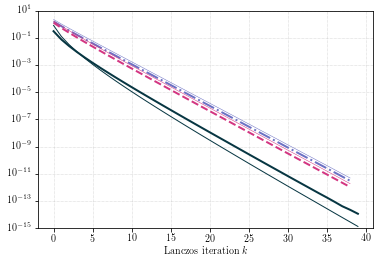

In [17]:
plt.figure(figsize=(6,4))

plt.plot(err_lanczos**2,linestyle='-',linewidth=1,color='#073642')
plt.plot(err_quad_form,linestyle='-',linewidth=2,color='#073642')

#plt.plot(sub_mult_bound,linestyle=(0,(4,2,1,3)),linewidth=1,color='#2aa198')
#plt.plot(triangle_bound,linestyle=(0,(7,5)),linewidth=1,color='#859900')
#plt.plot(full_bound,linestyle='-',linewidth=1,color='#b58900')

plt.plot(a_priori_bound*res_CG**2,linestyle='-.',linewidth=2,color='#6c71c4')
plt.plot(a_posteriori_bound*res_CG**2,linestyle='--',linewidth=2,color='#d33682')

plt.plot(a_priori_bound_approx_spectrum*res_CG**2,linestyle='-',linewidth=.5,color='#6c71c4')
plt.plot(a_posteriori_bound_approx_spectrum*res_CG**2,linestyle='-',linewidth=.5,color='#d33682')

#plt.plot(a_priori_bound*res_CG/lmin,linestyle='-.',linewidth=1,color='#6c71c4')
#plt.plot(a_posteriori_bound*res_CG/lmin,linestyle='--',linewidth=1,color='#d33682')


plt.yscale('log')

legend_elements = [Line2D([0],[0],linestyle='-',linewidth=1,color='#073642',label='$\| f(\mathbf{{A}})\mathbf{{b}} - \\textsf{lanc}_k(f) \|_2^2$'),
                   Line2D([0],[0],linestyle='-',linewidth=2,color='#073642',label=r'$| \mathbf{b}^{\footnotesize\textsf{H}} f(\mathbf{A}) \mathbf{b} - \mathbf{b}^{\footnotesize\textsf{H}} \textsf{lanc}_k(f) |$'),

                   Line2D([0],[0],linestyle='--',linewidth=2,color='#d33682',label='$(\\textrm{Q1}) \: \| \\textsf{resid}_k(w) \|_2^2$'),
                   Line2D([0],[0],linestyle='-.',linewidth=2,color='#6c71c4',label='$(\\textrm{Q2}) \: \| \\textsf{resid}_k(w) \|_2^2$'),
                   
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#073642',label='$\\exp(-4k/\\sqrt{\\kappa(\\mathbf{A}-w\\mathbf{I})})$')
                  ]

#plt.legend(handles=legend_elements,loc='lower left')

#for c in range(-10,14,3):
#    plt.plot(10**(c)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**(2*np.arange(K)),linestyle=':',linewidth=.5,color='#073642')

plt.ylim(1e-15,1e1)

plt.grid(True,linestyle=':',linewidth=.5)


#plt.title(f'quadratic form error bounds: $f(x) = \\log(x)$')
plt.xlabel('Lanczos iteration $k$')

plt.savefig('imgs/log_quadform.pdf',bbox_inches='tight')